# calculate Indian Ocean dipole index


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
from datetime import (datetime, timedelta)
from dateutil import parser

In [4]:
import xarray as xr

In [8]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    dset = xr.concat(datasets, dim)
    return dset

In [10]:
lfiles = glob('/Volumes/GDATA/data/SST/ERSST/V5/*.nc')

In [11]:
lfiles.sort() 

In [13]:
dset = xr.open_mfdataset(lfiles, concat_dim='time')

In [14]:
dset

<xarray.Dataset>
Dimensions:  (lat: 89, lev: 1, lon: 180, time: 812)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lev      (lev) float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 1950-03-01 ...
Data variables:
    sst      (time, lev, lat, lon) float64 dask.array<shape=(812, 1, 89, 180), chunksize=(1, 1, 89, 180)>
    ssta     (time, lev, lat, lon) float64 dask.array<shape=(812, 1, 89, 180), chunksize=(1, 1, 89, 180)>
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.195001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    institution:                NOAA/NESDIS/NCEI/CCOG
    creator_

In [15]:
def demean(x): 
    return x - x.sel(time=slice('1981','2010')).mean('time')

In [16]:
sst_anoms = dset['sst'].groupby('time.month').apply(demean)

In [17]:
EAST = sst_anoms.sel(lon=slice(90, 110), lat=slice(-10,0)).mean('lat').mean('lon')
WEST = sst_anoms.sel(lon=slice(50, 70), lat=slice(-10,10)).mean('lat').mean('lon')

In [18]:
time = EAST['time'].values

In [19]:
from scipy.stats import zscore

In [20]:
EAST = zscore(EAST.values.flatten())

/Users/nicolasf/anaconda3/envs/IOOS/lib/python3.5/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
WEST = zscore(WEST.values.flatten())

/Users/nicolasf/anaconda3/envs/IOOS/lib/python3.5/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [22]:
DMI = pd.DataFrame({'east':EAST, 'west':WEST}, index=time)

In [23]:
DMI = DMI.assign(dmi = DMI.west - DMI.east)

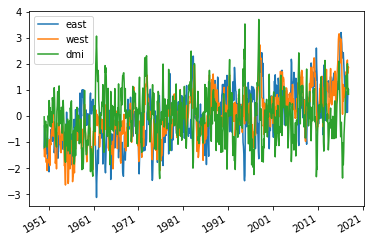

In [25]:
DMI.plot()

In [26]:
!ls ../../data/climate_drivers/

SAM_monthly_1950_2016_1981_2010_Clim_EOF_NCEP1.csv


In [27]:
DMI.to_csv('../../data/climate_drivers/IOD_monthly_1950_2016_1981_2010_Clim_ERSSTv5.csv')